In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [12]:
# CONSTANTS
# 0: 5 years dataset
# 1: 10 years dataset
DATA_SET_TO_LOAD = 0

# Defining the paths to the datasets
five_dataset_path = r'./data/raw/5_years.csv'
ten_dataset_path = r'./data/raw/10_years.csv'

# Defining the path to the dataset to be used
active_dataset_path = five_dataset_path if DATA_SET_TO_LOAD == 0 else ten_dataset_path

In [13]:
# Load the dataset
dataset = pd.read_csv(active_dataset_path, parse_dates=['Date'], index_col='Date')
print(dataset.head())

                Close       Open       High        Low  Adj Close     Volume
Date                                                                        
2019-01-02  39.480000  38.722500  39.712502  38.557499  37.845047  148158800
2019-01-03  35.547501  35.994999  36.430000  35.500000  34.075390  365248800
2019-01-04  37.064999  36.132500  37.137501  35.950001  35.530052  234428400
2019-01-07  36.982498  37.174999  37.207500  36.474998  35.450966  219111200
2019-01-08  37.687500  37.389999  37.955002  37.130001  36.126778  164101200


In [14]:
# Check for missing values
print(dataset.isnull().sum())

# Check for duplicates
print(dataset.duplicated().sum())

Close        0
Open         0
High         0
Low          0
Adj Close    0
Volume       0
dtype: int64
0


# NORMALIZE DATA

In [15]:
# Normalize the dataset
def normalize_features(df):
    '''
    Normalizes the features in the dataframe
    '''
    cols = df.columns.drop('Close')
    scaler = MinMaxScaler()
    df[cols] = scaler.fit_transform(
        df[cols])
    
    return df, scaler


def normalize_target(df):
    '''
    Normalizes the target variable
    '''
    scaler = MinMaxScaler()
    df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))[:,0]
    
    return df, scaler
    

# PREPARE AND LOAD DATA


In [16]:
def prepare_data(df, target_col, time_steps=60):
    '''
    Prepares the data for training the LSTM model
    '''
    
    x, y = [], []
    for i in range(len(df) - time_steps):
        x.append(df[i:i + time_steps])
        y.append(df[i + time_steps, target_col])
    return np.array(x), np.array(y)

In [17]:
def preprocess_data(df, method='f_fill', drop = False, constant_fill=0.0):
    '''
    Preprocesses the data for training the LSTM model
    '''
    
    # Handle missing values
    if method == 'f_fill':
        df.fillna(method='ffill', inplace=True)    
    elif method == 'b_fill':
        df.fillna(method='bfill', inplace=True)
    elif method == 'constant':
        df.fillna(constant_fill, inplace=True)

    # Drop missing values
    if drop:
        df.dropna(inplace=True)

    # Check for missing values
    print(df.isnull().sum())
    return df 

In [18]:
TIME_STEPS = 60

df = preprocess_data(dataset, method='b_fill')
features_df, features_scaler = normalize_features(df)
target_df, target_scaler = normalize_target(df)


# Prepare the data 
x,y = prepare_data(features_df.values, target_df.columns.get_loc('Close'), TIME_STEPS)

# Create the training and testing and validation datasets (80% train, 10% test, 10% validation)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

# Print the shapes of the datasets
print(x_train.shape, x_test.shape, x_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

Close        0
Open         0
High         0
Low          0
Adj Close    0
Volume       0
dtype: int64
(958, 60, 6) (120, 60, 6) (120, 60, 6)
(958,) (120,) (120,)


C:\Users\radua\AppData\Local\Temp\ipykernel_3944\3023603184.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


# SVM

In [25]:
# SVR model
model = SVR(kernel='linear', gamma=0.0013, C=3.72, epsilon=0.05)

# Fit the model
model.fit(x_train.reshape(x_train.shape[0], -1), y_train)

SVR(C=3.72, epsilon=0.05, gamma=0.0013, kernel='linear')

Train Error: 0.0005540835840636272
Test Error: 0.0004240581412643948


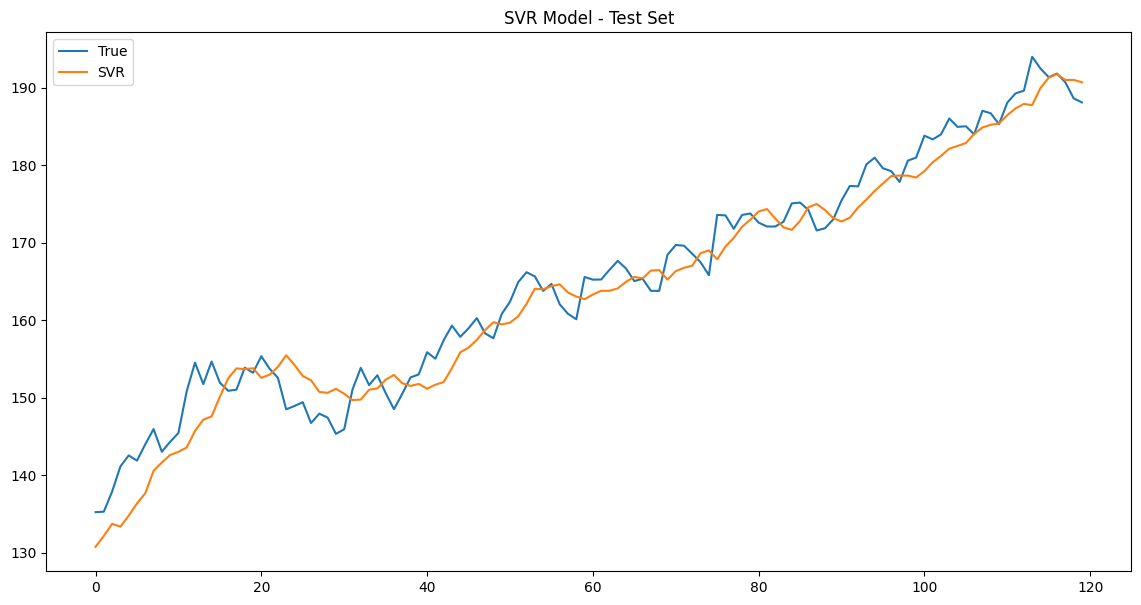

In [26]:
# Make predictions
train_pred_i = model.predict(x_train.reshape(x_train.shape[0], -1))
test_pred_i = model.predict(x_test.reshape(x_test.shape[0], -1))

# Inverse the normalization
y_test_inverted = target_scaler.inverse_transform(y_test.reshape(-1, 1))
test_pred = target_scaler.inverse_transform(test_pred_i.reshape(-1, 1))

# Calculate the mean squared error
train_error = mean_squared_error(y_train, train_pred_i)
test_error = mean_squared_error(y_test, test_pred_i)

print('Train Error:', train_error)
print('Test Error:', test_error)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverted, label='True')
plt.plot(test_pred, label='SVR')
plt.title('SVR Model - Test Set')
plt.legend()
plt.show()

# Validation

Validation Error: 0.0005562457736374004


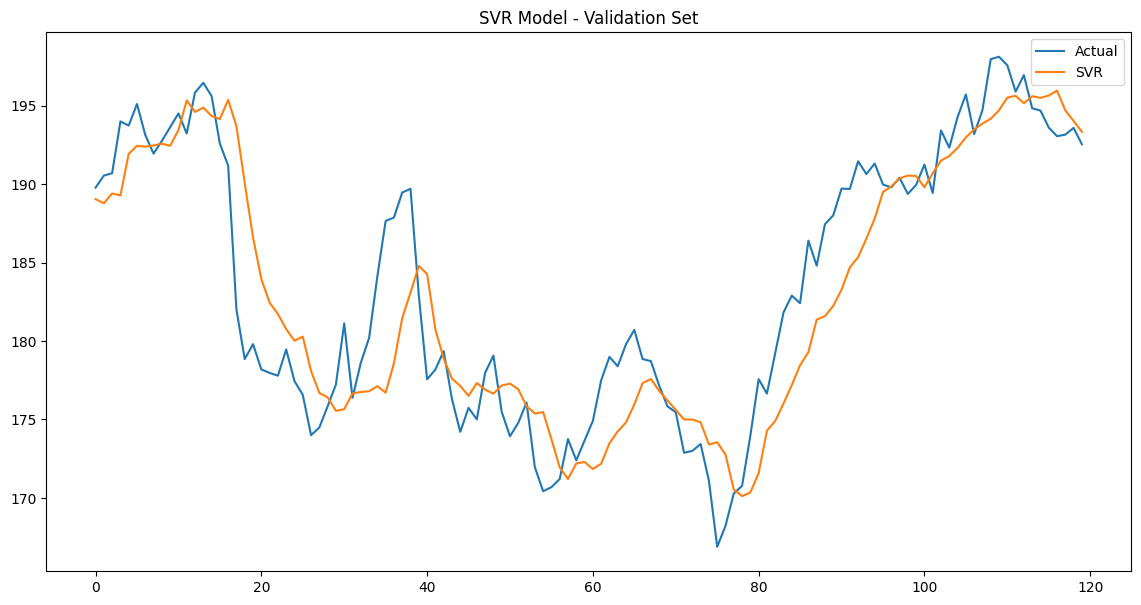

In [27]:
val_pred = model.predict(x_val.reshape(x_val.shape[0], -1))
val_error = mean_squared_error(y_val, val_pred)
print('Validation Error:', val_error)

# Inverse the normalization
y_val_inverted = target_scaler.inverse_transform(y_val.reshape(-1, 1))
val_pred = target_scaler.inverse_transform(val_pred.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_val_inverted, label='Actual')
plt.plot(val_pred, label='SVR')
plt.title('SVR Model - Validation Set')
plt.legend()
plt.show()

# Extras

## Parameter Search

In [9]:
from sklearn.model_selection import GridSearchCV

In [21]:
# Cross validation grid search (best parameters) 
c_range = np.logspace(-0, 4, 8)
gamma_range = np.logspace(-4, 0, 8)
tuned_parameters = [{'kernel': ['rbf'],'C': c_range,'gamma':gamma_range},
                    {'kernel': ['linear'], 'C': c_range,'gamma':gamma_range}]

svr = SVR()
clf = GridSearchCV(svr, param_grid=tuned_parameters, verbose=1, n_jobs=-1, cv=4,
                   scoring='neg_mean_squared_error')
clf.fit(x_train.reshape(x_train.shape[0], -1), y_train)

print('Best score for data:', clf.best_score_)
print('Best C:',clf.best_estimator_.C) 
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)

Fitting 4 folds for each of 128 candidates, totalling 512 fits
Best score for data: -0.002712162918197209
Best C: 3.72759372031494
Best Kernel: rbf
Best Gamma: 0.0013894954943731374


In [132]:
# Cross validation grid search (best parameters) 
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
epsilon_range = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
# tuned_parameters = [{'kernel': ['rbf'],'C': c_range,'gamma':gamma_range,'epsilon':epsilon_range}]
tuned_parameters = [{'kernel': ['linear'], 'C': c_range,'gamma':gamma_range,'epsilon':epsilon_range}]
# coef_range = np.logspace(-4, 0, 8)
# tuned_parameters = [{'kernel': ['sigmoid'], 'C': c_range,'gamma':gamma_range,'epsilon':epsilon_range, 'coef0':coef_range}]
# poly_range = np.arange(2, 6)
# tuned_parameters = [{'kernel': ['poly'], 'C': c_range,'gamma':gamma_range,'epsilon':epsilon_range,'degree':poly_range, 'coef0':coef_range}]

svr = SVR()
clf = GridSearchCV(svr,param_grid=tuned_parameters,verbose=1,n_jobs=-1,cv=4,
                   scoring='neg_mean_squared_error')
clf.fit(x_train.reshape(x_train.shape[0], -1), y_train)

print('Best score for data:', clf.best_score_)
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best C:',clf.best_estimator_.C) 
print('Best Gamma:',clf.best_estimator_.gamma)
print('Best Epsilon:',clf.best_estimator_.epsilon)

if clf.best_estimator_.kernel == 'poly':
    model = SVR(kernel=clf.best_estimator_.kernel, gamma=clf.best_estimator_.gamma, C=clf.best_estimator_.C,\
                 epsilon=clf.best_estimator_.epsilon, degree=clf.best_estimator_.degree, coef0=clf.best_estimator_.coef0)
elif clf.best_estimator_.kernel == 'sigmoid':
    model = SVR(kernel=clf.best_estimator_.kernel, gamma=clf.best_estimator_.gamma, C=clf.best_estimator_.C,\
                 epsilon=clf.best_estimator_.epsilon, coef0=clf.best_estimator_.coef0)
else:
    model = SVR(kernel=clf.best_estimator_.kernel, gamma=clf.best_estimator_.gamma, C=clf.best_estimator_.C,\
                 epsilon=clf.best_estimator_.epsilon)
   
 
model.fit(x_train.reshape(x_train.shape[0], -1), y_train)

# Make predictions
train_pred = model.predict(x_train.reshape(x_train.shape[0], -1))
test_pred = model.predict(x_test.reshape(x_test.shape[0], -1))

# Calculate the mean squared error
train_error = mean_squared_error(y_train, train_pred)
test_error = mean_squared_error(y_test, test_pred)

print('Train Error:', train_error)
print('Test Error:', test_error)

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='True')
plt.plot(test_pred, label='SVR')
plt.ylim(0, 1)
plt.text(0, 0.01, 'Train Error: %.6f'%train_error)
plt.text(0, 0.05, 'Test Error: %.6f'%test_error)
plt.title('SVR Model ' + clf.best_estimator_.kernel)
plt.legend()
plt.savefig(f'SVR {clf.best_estimator_.kernel}.png')
plt.show()

Fitting 4 folds for each of 336 candidates, totalling 1344 fits


KeyboardInterrupt: 

[1.02329299]


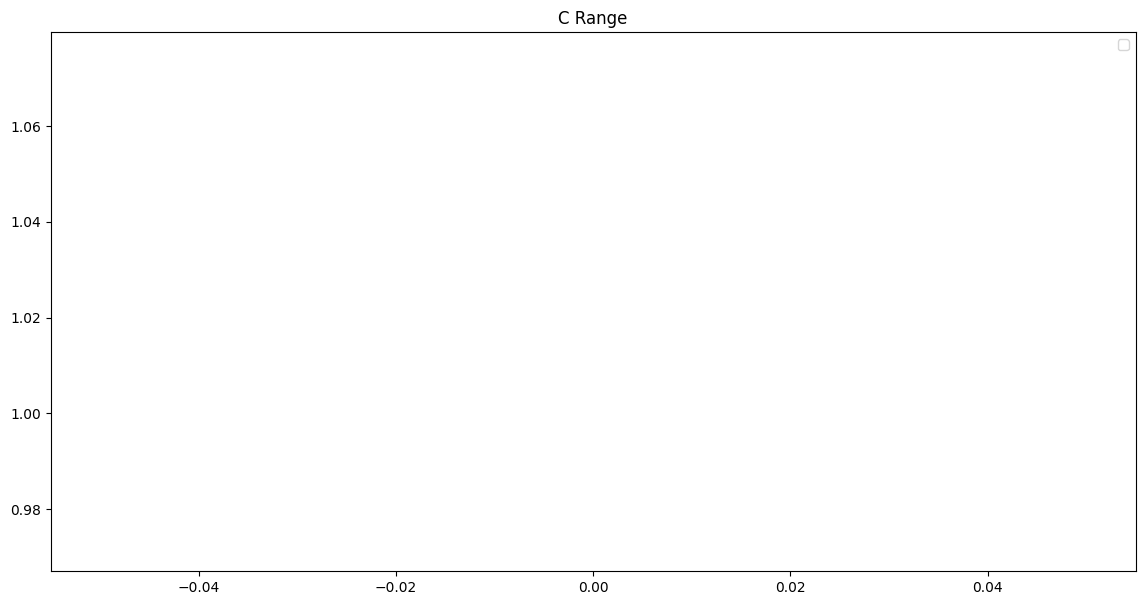

In [ ]:
print(epsilon_range)

#plot c_range
plt.figure(figsize=(14, 7))
plt.plot(epsilon_range)
plt.title('C Range')
plt.legend()
plt.show()
